# Designing Quantum Error-Correcting Codes


In [1]:
%matplotlib inline

/home/angelo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import numpy as np
import stim
import sinter
import model

import matplotlib.pyplot as plt

In [3]:
# Edit matplotlib parameters
plt.rcParams.update({
    'text.usetex': True,  # WARNING: make false if no TeX compiler installed
    'font.family': "Serif",
    'figure.dpi': 300
})

In [4]:
surface_code = model.StabilizerModel("surface_code:x_memory", scale=(3,3), rounds=2)

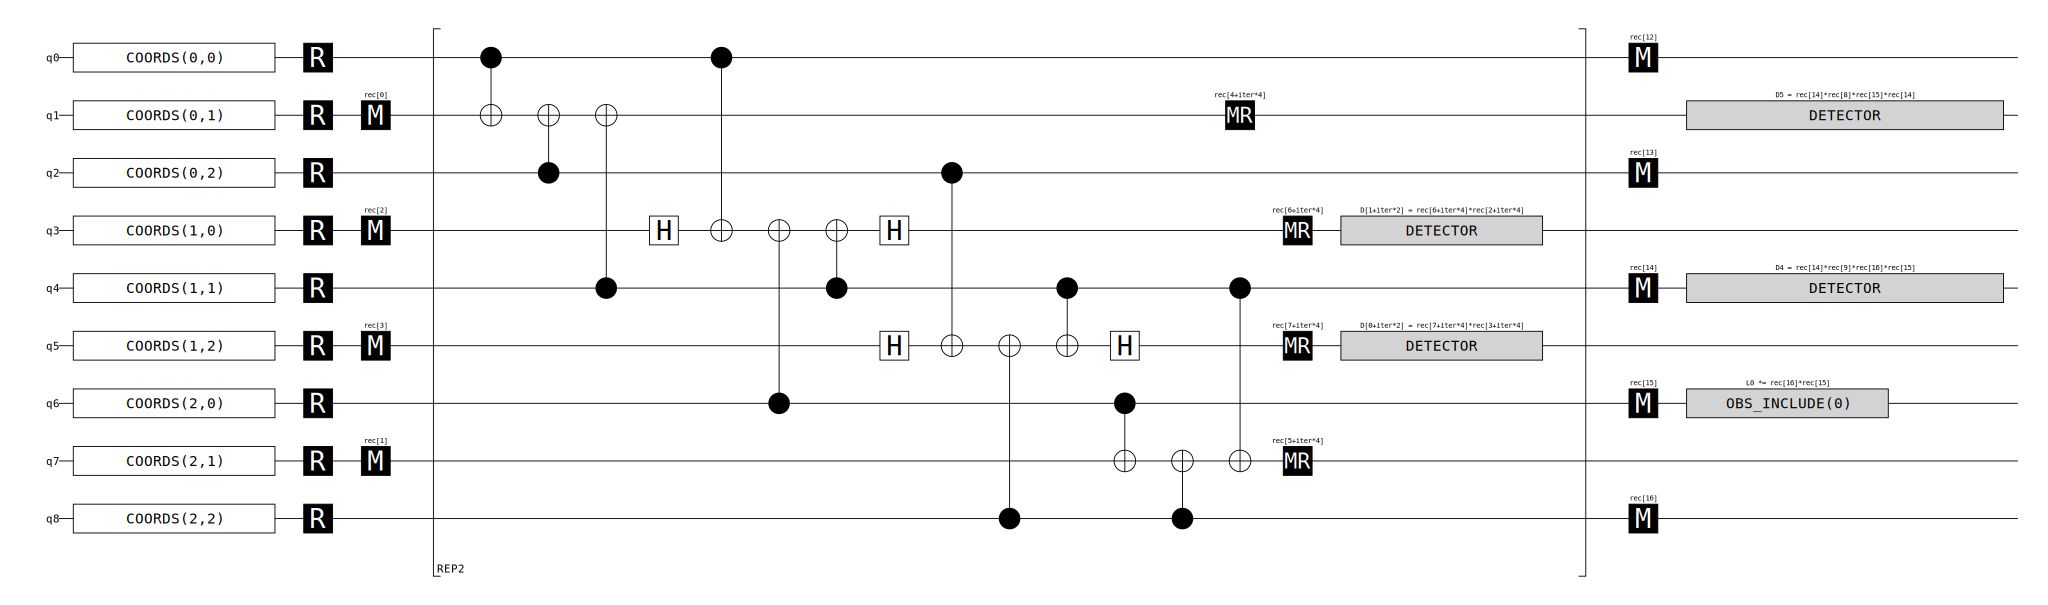

In [6]:
surface_code.circuit.without_noise().diagram("timeline")

In [6]:
surface_code_tasks = [
    sinter.Task(
        circuit=model.StabilizerModel(
            "surface_code:z_memory",
            scale=(distance, distance),
            rounds=distance * 3,
            noise_circuit=0.0,
            noise_data=noise,
            noise_x_check=noise,
            noise_z_check=noise,
        ).circuit,
        json_metadata={"distance": distance, "rounds": distance * 3, "noise": noise},
    )
    for distance in [5, 7, 9]
    for noise in np.linspace(0.001, 0.10, 40)
]

In [7]:
collected_surface_code_stats = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=["pymatching"],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=True,
)

Starting 4 workers...
117 cases left:
    pymatching processes=4  ~core_mins_left=1       shots_left=951400   errors_left=3893    {distance=5,noise=0.008615384615384615,rounds=15}
    pymatching processes=0  ~core_mins_left=1       shots_left=999100   errors_left=4978    {distance=5,noise=0.011153846153846153,rounds=15}
80 cases left:
    pymatching processes=4  ~core_mins_left=1       shots_left=935200   errors_left=4996    {distance=7,noise=0.001,rounds=21}
    pymatching processes=0  ~core_mins_left=1       shots_left=999900   errors_left=5000    {distance=7,noise=0.0035384615384615385,rounds=21}
78 cases left:
    pymatching processes=4  ~core_mins_left=1       shots_left=910900   errors_left=4549    {distance=7,noise=0.006076923076923077,rounds=21}
    pymatching processes=0  ~core_mins_left=None    shots_left=1000000  errors_left=5000    {distance=7,noise=0.008615384615384615,rounds=21}
77 cases left:
    pymatching processes=1  ~core_mins_left=1       shots_left=731556   errors_

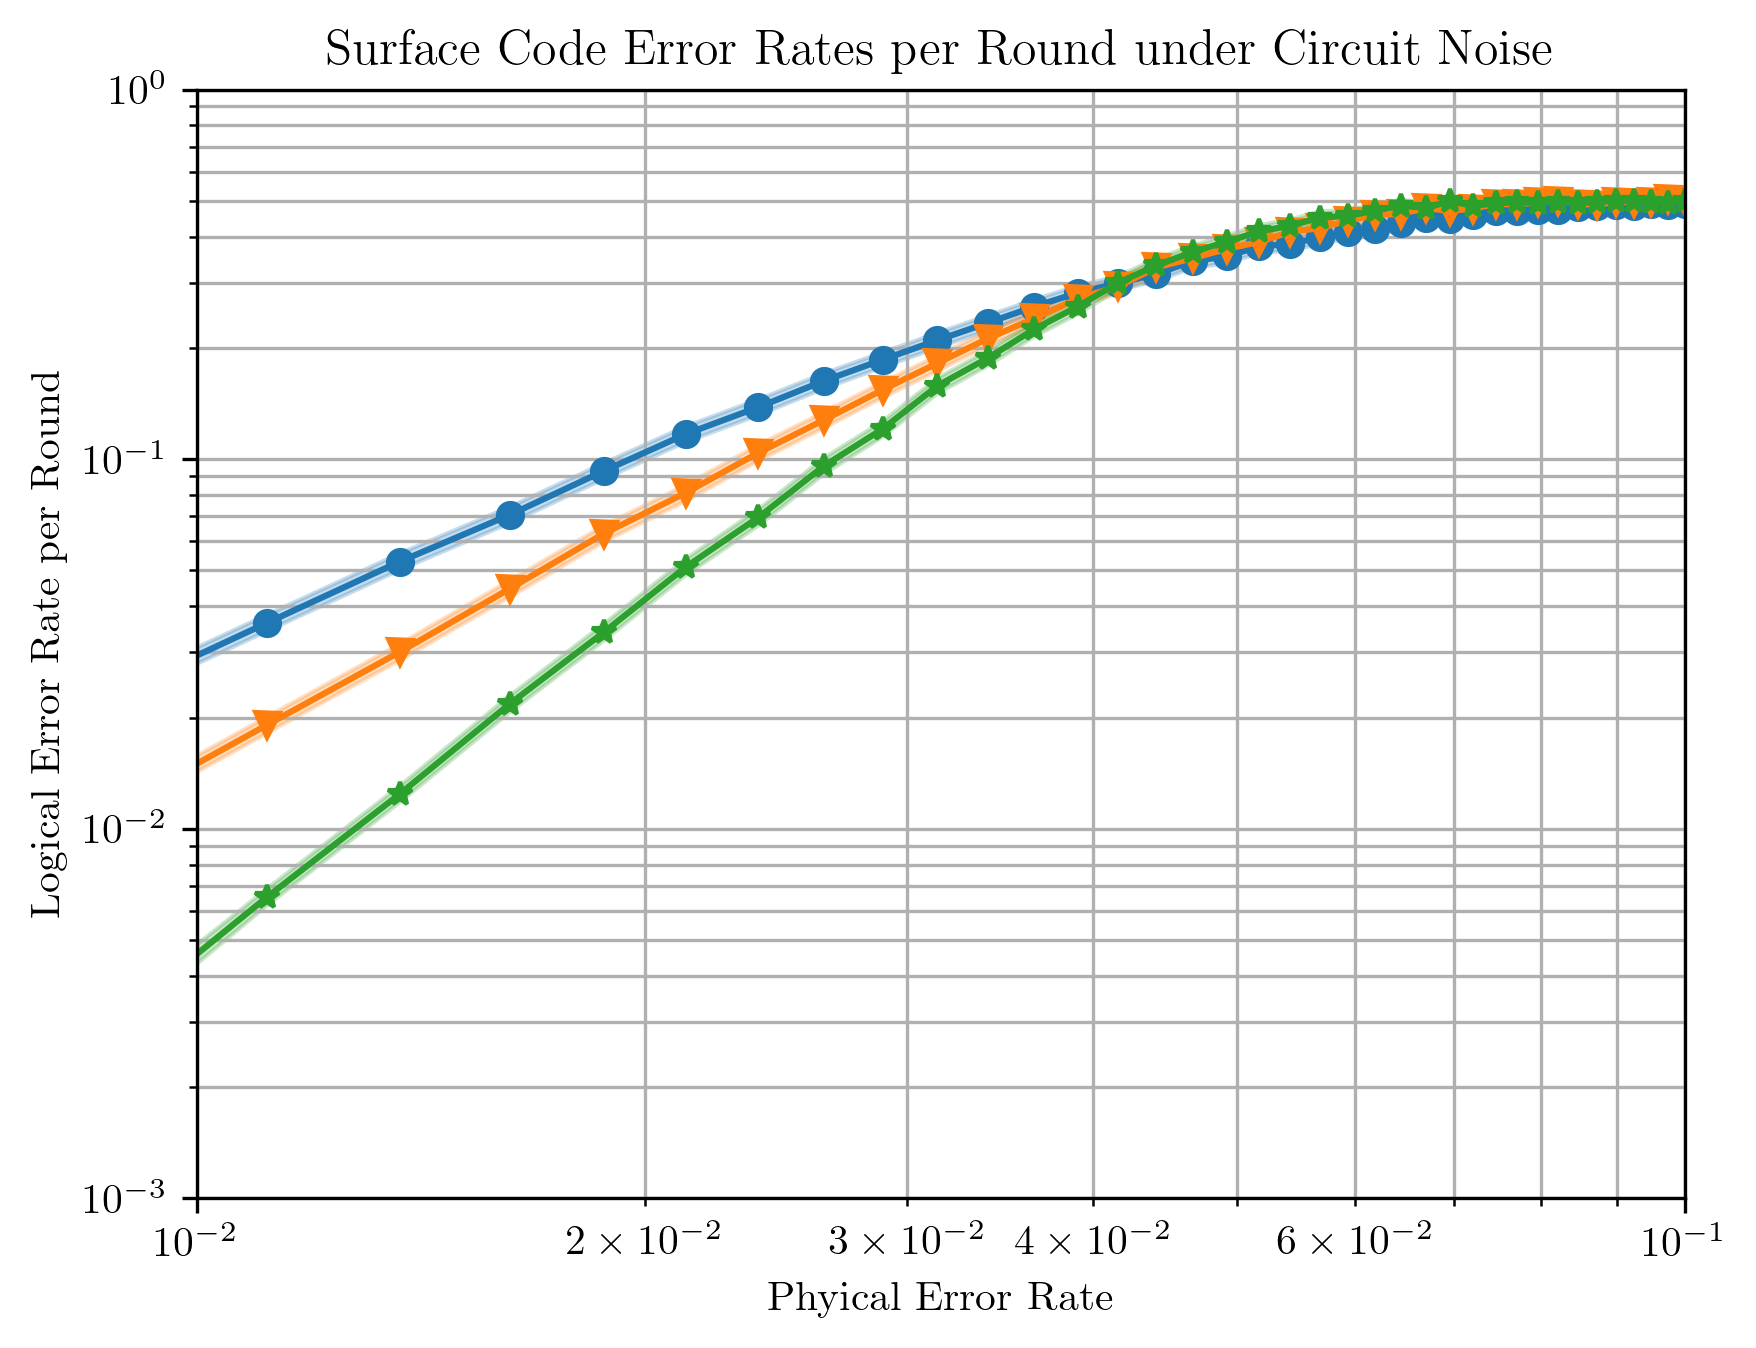

In [8]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['noise'],
    group_func=lambda stat: stat.json_metadata['distance'],
    # failure_units_per_shot_func=lambda stat: stat.json_metadata['round'],
)
ax.set_ylim(1e-3, 1)
ax.set_xlim(1e-2, 0.1)
ax.loglog()
ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')